# T4 Árboles, bosques, bagging y boosting

**Índice**

> 1 CART<br>
>> 1.1 Árbol de regresión<br>
>> 1.2 Árbol de clasificación<br>
>
> 2 Aprendizaje de ensambles<br>
>> 2.1 Aprendizaje de ensambles<br>
>> 2.2 Bagging<br>
>> 2.3 Random forests<br>
>
> 3 Boosting<br>
>> 3.1 Boosting<br>
>> 3.2 Modelado aditivo por etapas hacia adelante<br>
>> 3.3 Boosting mínimos cuadrados<br>
>> 3.4 AdaBoost<br>
>>> 3.4.1 Objetivo FSAM con pérdida exponencial<br>
>>> 3.4.2 Minimización del objetivo en dos pasos<br>
>>> 3.4.3 Adaboost<br>
>>> 3.4.4 Propiedades de Adaboost<br>
>>
>> 3.5 LogitBoost<br>
>> 3.6 Gradient boosting<br>
>>> 3.6.1 Algoritmo básico<br>
>>> 3.6.2 Regresión<br>
>>> 3.6.3 Clasificación binaria<br>
>>> 3.6.4 Clasificación multiclase<br>
>>> 3.6.5 Gradient tree boosting<br>
>>> 3.6.6 XGBoost<br>
>
> 4 Interpretación de ensambles de árboles<br>
>> 4.1 Importancia de características<br>
>> 4.2 Gráficos de dependencia parcial<br>

# 1 CART

**Classification and regression trees (CART):** $\;$ árboles que particionan el espacio de entrada recursivamente hasta alcanzar las hojas, cada una de ellas caracterizada por la región en la que se aplica y su (modelo de) predicción correspondiente
* Dada una entrada $\boldsymbol{x}\in\mathbb{R}^D$, un árbol puede verse como un conjunto de reglas de decisión anidadas hasta alcanzar las hojas
* Cada regla de decisión o **nodo interno** $i$ define un **split paralelo a un eje:** $\,$ compara una característica $d_i$ de la entrada con un umbral $t_i$ y, si $\boldsymbol{x}_{d_i}\leq t_i$, $\;\boldsymbol{x}$ se sigue procesando por la rama izquierda; si no, se procesa por la derecha
* El procesamiento de $\boldsymbol{x}$ termina al llegar a un nodo hoja, donde se especifica la salida predicha para toda entrada dentro de su región asociada, esto es, la región acorde con los splits definidos en sus nodos antecesores

### 1.1 Árbol de regresión

**Árbol de regresión:** $\;\boldsymbol{\theta}=\{(R_j, w_j): j=1:J\},\,$ de $J$ hojas, donde $R_j$ y $w_j$ denotan la región y salida asociadas a la hoja $j$
$$f(\boldsymbol{x};\boldsymbol{\theta})=\sum_{j=1}^J w_j\,\mathbb{I}(\boldsymbol{x}\in R_j)$$

**Aprendizaje de las salidas:** $\;$ se suele usar la media de las salidas de los datos de entrenamiento en cada hoja

**Ejemplo:** $\;$ árbol de regresión para entradas 2d con $4$ nodos internos y $5$ hojas

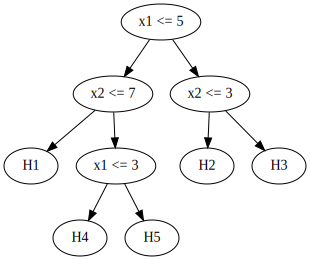

In [1]:
from graphviz import Digraph

t = Digraph()
t.node('N1', 'x1 <= 5'); 
with t.subgraph() as s:
    s.attr(rank='same')
    s.node('N2', 'x2 <= 7')
    s.node('N3', 'x2 <= 3')
with t.subgraph() as s:
    s.attr(rank='same')
    s.node('H1')
    s.node('N4', 'x1 <= 3')
    s.node('H2')
    s.node('H3')
with t.subgraph() as s:
    s.attr(rank='same')
    s.node('H4')
    s.node('H5')
t.edge('N1', 'N2'); t.edge('N1', 'N3')
t.edge('N2', 'H1'); t.edge('N2', 'N4')
t.edge('N3', 'H2'); t.edge('N3', 'H3')
t.edge('N4', 'H4'); t.edge('N4', 'H5')
t

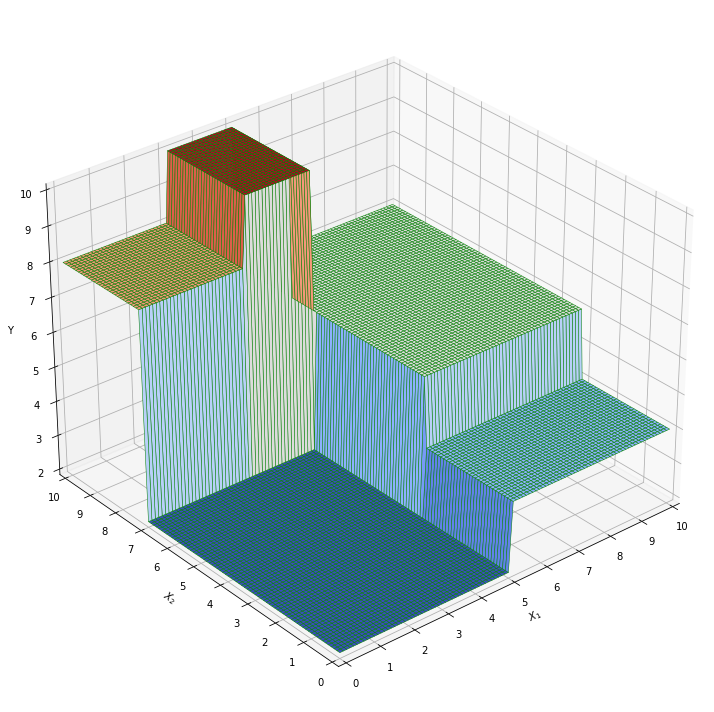

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x11 = 5; x12 = 3; x21 = 7; x22 = 3 # umbrales de corte
h = 0.1; M = 10; X1 = X2 = np.arange(0, M + h, h)
L1 = X1 <= x11; R1 = X2 <= x21 # hoja 1
L2 = X1 > x11;  R2 = X2 <= x22 # hoja 2
L3 = X1 > x11;  R3 = X2 > x22  # hoja 3
L4 = X1 <= min(x11, x22); R4 = X2 > x21 # hoja 4
L5 = (X1 <= x11) & (X1 > x12); R5 = X2 > x21 # hoja 5
tree = np.zeros((len(X1), len(X2)))
r = np.arange(2, 12, 2) # [ 2  4  6  8 10]
for i in range(len(tree)):
    for j in range(len(tree[0])):
        if L1[i] & R1[j]:
            tree[i, j] = r[0] # salida de la hoja 1
        if L2[i] & R2[j]:
            tree[i, j] = r[1] # salida de la hoja 2
        if L3[i] & R3[j]:
            tree[i, j] = r[2] # salida de la hoja 3
        if L4[i] & R4[j]:
            tree[i, j] = r[3] # salida de la hoja 4
        if L5[i] & R5[j]:
            tree[i, j] = r[4] # salida de la hoja 5
X, Y = np.meshgrid(X1, X2, indexing="ij")
ax = plt.figure(figsize=(10, 10)).add_subplot(projection="3d")
ax.plot_surface(X, Y, tree, cmap="coolwarm", lw=0.5, rstride=1, cstride=1, edgecolor=["g"], color="w", antialiased=True)
ax.set_xlabel("$X_1$"); ax.set_xticks(range(11)); ax.set_xmargin(0.001)
ax.set_ylabel("$X_2$"); ax.set_yticks(range(11)); ax.set_ymargin(0.001)
ax.set_zlabel("Y")
ax.view_init(None, 50 + 180)
plt.tight_layout()

### 1.2 Árbol de clasificación

**Árbol de clasificación:** $\;$ las hojas contienen una distribución sobre las etiquetas de clase en lugar de una respuesta promedio

## 1.2 Ajuste

**Ajuste de un árbol de $J$ hojas:** $\;$ minimización en $\boldsymbol{\theta}=\{(R_j, w_j): j=1:J\}$ de la pérdida empírica
$$\mathcal{L}(\boldsymbol{\theta})%
=\sum_n\ell(y_n,f(\boldsymbol{x};\boldsymbol{\theta}))%
=\sum_j\sum_{\boldsymbol{x}_n\in R_j}\ell(y_n,w_j)$$

**Dificultad:** $\;$ la pérdida no es diferenciable pues debemos aprender la estructura del árbol y encontrar una óptima es un problema NP-duro

**Soluciones aproximadas:** $\;$ métodos voraces como **CART, C4.5 o ID3,** que hacen crecer el árbol añadiendo un nodo en cada iteración

### 1.2.1 Splits de un nodo

**Splits de un nodo $i$ con base en una característica $j$:** $\;$ a partir de los datos que alcanzan $i$, $\mathcal{D}_i=\{(\boldsymbol{x}_n,y_n)\}$
* Si $j$ es real, podemos definir un split por cada umbral $t\in\mathcal{T}_j$, con $\mathcal{T}_j=\{x_{nj}\}$ por ejemplo, tal que:
$$\begin{align*}
\mathcal{D}_i^L(j,t)&=\{(\boldsymbol{x}_n,y_n)\in\mathcal{D}_i:x_{nj}\leq t\}\\%
\mathcal{D}_i^R(j,t)&=\{(\boldsymbol{x}_n,y_n)\in\mathcal{D}_i:x_{nj}> t\}
\end{align*}$$
* Si $j$ es categórica, podemos definir un split por cada $t$ igual a $K_j$ valores posibles
$$\begin{align*}
\mathcal{D}_i^L(j,t)&=\{(\boldsymbol{x}_n,y_n)\in\mathcal{D}_i:x_{nj}=t\}\\%
\mathcal{D}_i^R(j,t)&=\{(\boldsymbol{x}_n,y_n)\in\mathcal{D}_i:x_{nj}\neq t\}
\end{align*}$$

### 1.2.2 Elección del mejor split

**Coste o impureza de un nodo:** $\;$ definimos una función $c(\cdot)$ para evaluarla, independiente del tamaño del nodo

**Mejor split de un nodo $i$:** $\;$ uno que reduzca al máximo su coste, esto es, que minimice la suma de los costes normalizados de los hijos
$$(j_i,t_i)=\operatorname*{arg}
\min_{j\in\{1,\dotsc,D\}}\min_{t\in\mathcal{T}_j}\;%
\frac{\lvert\mathcal{D}_i^L(j,t)\rvert}{\lvert\mathcal{D}_i\rvert}\,c(\mathcal{D}_i^L(j,t))+%
\frac{\lvert\mathcal{D}_i^R(j,t)\rvert}{\lvert\mathcal{D}_i\rvert}\,c(\mathcal{D}_i^R(j,t))$$

**Coste de un nodo en regresión:** $\;$ se suele usar el **error cuadrático medio** (con respecto a la respuesta media del nodo)
$$c(\mathcal{D}_i)=\frac{1}{\lvert\mathcal{D}_i\rvert}%
\sum_{(\boldsymbol{x}_n,y_n)\in\mathcal{D}_i}(y_n-\bar{y})^2%
\qquad\text{con}\qquad%
\bar{y}=\frac{1}{\lvert\mathcal{D}_i\rvert}\sum_{(\boldsymbol{x}_n,y_n)\in\mathcal{D}_i} y_n$$

**Coste de un nodo en clasificación:** $\;$ las funciones usuales se basan en la distribución empírica de las clases en el nodo
$$\hat{\pi}_{ic}=\frac{1}{\lvert\mathcal{D}_i\rvert}%
\sum_{(\boldsymbol{x}_n,y_n)\in\mathcal{D}_i}\mathbb{I}(y_n=c)$$

**Índice Gini:** $\;$ mide el error de clasificación esperado en el nodo $i$; esto es, la probabilidad de que un dato al azar se clasifique mal si su clase se determina aleatoriamente según las probabilidades de las clases
$$G_i=\sum_c \hat{\pi}_{ic}(1-\hat{\pi}_{ic})%
=\sum_c \hat{\pi}_{ic} - \sum_c \hat{\pi}_{ic}^2%
=1-\sum_c \hat{\pi}_{ic}^2$$

**Entropía:** $\;$ de la distribución empírica de las clases en el nodo
$$H_i=\mathbb{H}(\hat{\boldsymbol{\pi}}_i)=-\sum_c\hat{\pi}_{ic}\log\hat{\pi}_{ic}$$
* **Mínima entropía:** $\;\hat{\pi}_{ic}=\delta(c=c^*)\,\Rightarrow\,H_i=-1\log 1-\sum_{c\neq c^*}0\,\log 0=0$
* **Máxima entropía:** $\;\hat{\pi}_{ic}=1/C\,\Rightarrow\,H_i=-\sum_{c=1}^C\frac{1}{C}\log\frac{1}{C}=-\log\frac{1}{C}=\log C$

**Ejemplo:** $\;\mathcal{D}_i=\{((1,1)^t, 1), ((2, 4)^t, 2), ((5, 1)^t, 1), ((5, 4)^t, 1)\}$

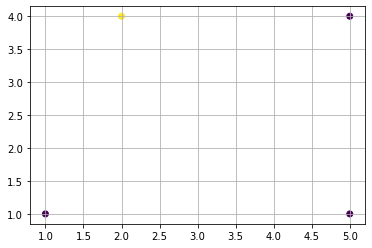

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
X = np.array(([1, 1], [2, 4], [5, 1], [5, 4]), dtype=float)
y = np.array([1, 2, 1, 1])
plt.grid(); plt.scatter(*X.T, c=y);

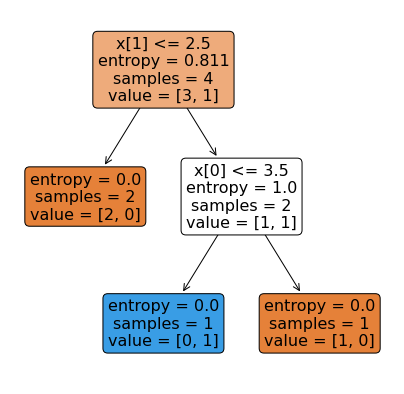

In [2]:
dt = DecisionTreeClassifier(criterion='entropy').fit(X, y) # prueba 'gini' y 'entropy'
plt.figure(figsize=(7, 7))
plot_tree(dt, filled=True, rounded=True, fontsize=16);

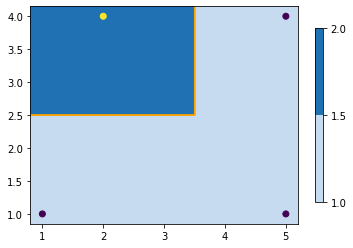

In [3]:
fix, ax = plt.subplots()
ax.scatter(*X.T, c=y); x_min, x_max = ax.get_xlim(); y_min, y_max = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=1000), np.linspace(y_min, y_max, num=1000))
zz = dt.predict(np.c_[xx.ravel(), yy.ravel()])
ax.contour(xx, yy, zz.reshape(xx.shape), 1, colors='orange', linestyles='solid')
cp = ax.contourf(xx, yy, zz.reshape(xx.shape), 1, cmap='Blues')
plt.colorbar(cp, ax=ax, shrink=0.8); ax.scatter(*X.T, c=y);

## 1.3 Regularización

**Sobre-entrenamiento:** $\;$ si dejamos que un árbol crezca incontroladamente, podemos ajustarlo de manera que no cometa ningún error en entrenamiento (salvo ruido de etiquetas), pero funcione mal con datos futuros

**Regularización:** $\;$ se suelen aplicar técnicas que limitan el tamaño del árbol

**Aproximación directa:** $\;$ parar el crecimiento al tener pocos ejemplos en un nodo o alcanzar una profundidad máxima

**Aproximación alternativa:** $\;$ dejar crecer el árbol al máximo y luego podarlo de hijos a padres mediante fusión de hijos

## 1.4 Características perdidas

**Ventaja:** $\;$ a diferencia de otros modelos discriminativos, el manejo de datos con características perdidas es sencillo con árboles

**Splits subrogados:** $\;$ heurístico estándar que, en caso de pérdida de una variable en inferencia, emplea variables de reserva que inducen particiones similares a las que induce la variable perdida

**Variables categóricas perdidas:** $\;$ se añade un nuevo valor "perdido" y los datos se tratan como complemente observados

## 1.5 Ventajas e incovenientes

### 1.5.1 Ventajas

* Son fáciles de interpretar
* Manejan fácilmente entradas mixtas, discretas y continuas
* Son insensibles a transformaciones monótonas de las entradas ya que los puntos de split se basan en la ordenación de los datos, por lo que no es necesario estandarizarlos
* Realizan selección de variables automáticamente
* De ajuste rápido y fácil escalado a grandes conjuntos de datos
* Pueden manejar caracterı́sticas de entrada perdidas

### 1.5.2 Incovenientes

* No son muy precisos, debido en parte a su construcción voraz
* **Inestabilidad:** pequeños cambios en los datos de entrada pueden tener grandes consecuencias en la estructura del árbol

**Ejemplo:** inestabilidad con iris

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
iris = load_iris()
ndx = [2, 3]  # petal length and width
X = iris.data[:, ndx]
y = iris.target

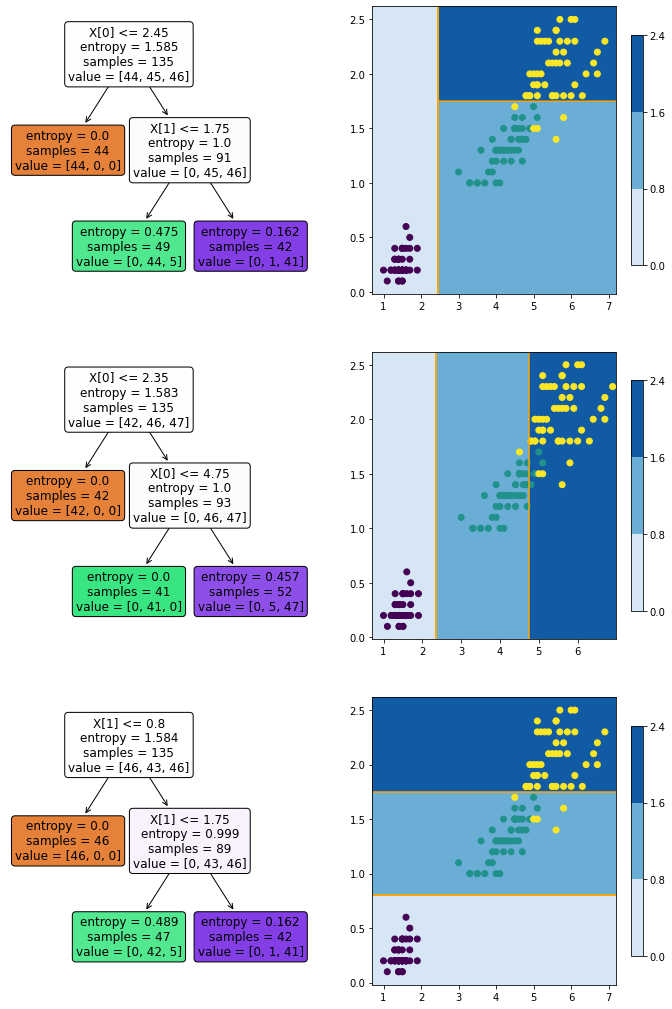

In [2]:
nrows = 3
fig, axes = plt.subplots(nrows, 2, figsize=(12, 6 * nrows))
for n in np.arange(nrows):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=2).fit(X_train, y_train)
    plot_tree(dt, filled=True, rounded=True, ax=axes[n, 0], fontsize=12);
    ax = axes[n, 1]; ax.scatter(*X_train.T, c=y_train); x_min, x_max = ax.get_xlim(); y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=1000), np.linspace(y_min, y_max, num=1000))
    zz = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    ax.contour(xx, yy, zz.reshape(xx.shape), 2, colors='orange', linestyles='solid')
    cp = ax.contourf(xx, yy, zz.reshape(xx.shape), 2, cmap='Blues')
    plt.colorbar(cp, ax=ax, shrink=0.8); ax.scatter(*X.T, c=y);

# 2 Aprendizaje de ensambles

**Los árboles constituyen un estimador de alta varianza:** $\;$ pequeñas perturbaciones de los datos resultan en predicciones muy distintas

## 2.1 Aprendizaje de ensambles

**Aprendizaje de ensambles:** $\;$ reduce la varianza de los árboles promediando $M$ modelos base $\{f_m\}$
$$f(y\mid\boldsymbol{x})=\frac{1}{M}\sum_{m=1}^M f_m(y\mid\boldsymbol{x})$$

**Ensamble en regresión:** $\;$ estimador de sesgo similar al de los modelos base pero, en general, de mejor precisión por la menor varianza

**Ensamble en clasificación:** $\;$ la salida se decide por el **método comité,** esto es, por voto mayoritario

**Probabilidad de acierto de un comité:** $\;$ $M$ modelos base independientes para clasificación binaria; todos con probabilidad de acierto $\theta$
* Dada una muestra la clase $1$, la clase escogida por el modelo base $m$ puede verse com una Bernoulli $Y_m\in\{0,1\}$, para todo $m$
* Así, la suma de los votos a la clase $1$, $S=\sum_m Y_m$, es una binomial $\operatorname{Bin}(M, \theta)$
* En definitiva, la probabilidad de acierto del comité puede hallarse a partir de la función de distribución binomial:
$$p=P(S>M/2)=1-B(M/2,M,\theta)%
\qquad\text{($B$ es la función de distribución binomial)}$$

In [1]:
from scipy.stats import binom
M = 1000; theta = 0.51
p = 1.0 - binom.cdf(M/2, M, theta)
print('{} predictores independientes con theta = {:.4f} acertarán con p = {:.4f}'.format(M, theta, p))

1000 predictores independientes con theta = 0.5100 acertarán con p = 0.7261


## 2.2 Bagging

**Bagging (bootstrap aggregating):** $\;$ ensambla $M$ modelos ajustados con diferentes versiones de los datos, obtenidas por boostraping (muestreo con reemplazamiento)

**Desventaja:** $\;$ cada modelo base ve un $63\%$ de datos aprox.; en el límite, la probabilidad de que un dato no se seleccione es
$$p=\lim_{N\to\infty} (1-1/N)^N=e^{-1}\approx 0.37$$

**Ventaja:** $\;$ el $37\%$ de muestras **out-of-bag** puede usarse en test

**Ventaja principal:** $\;$ el ensamble no depende demasiado de ningún dato individual, lo que favorece mayor robustez y generalización

**Ejemplo:** $\;$ bagging de árboles

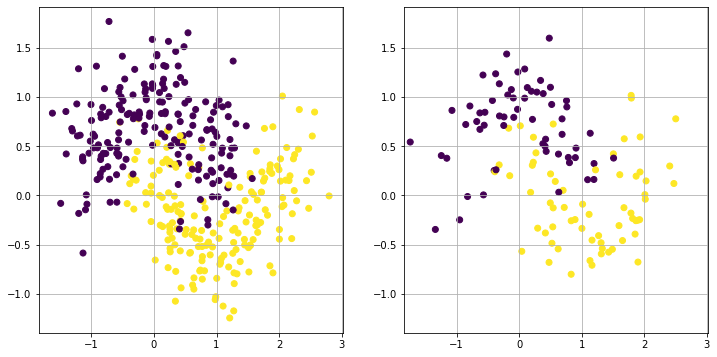

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax=axes[0]; ax.grid(); ax.scatter(*X_train.T, c=y_train)
x_min, x_max = ax.get_xlim(); y_min, y_max = ax.get_ylim()
ax=axes[1]; ax.grid(); ax.scatter(*X_test.T, c=y_test)
ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max);

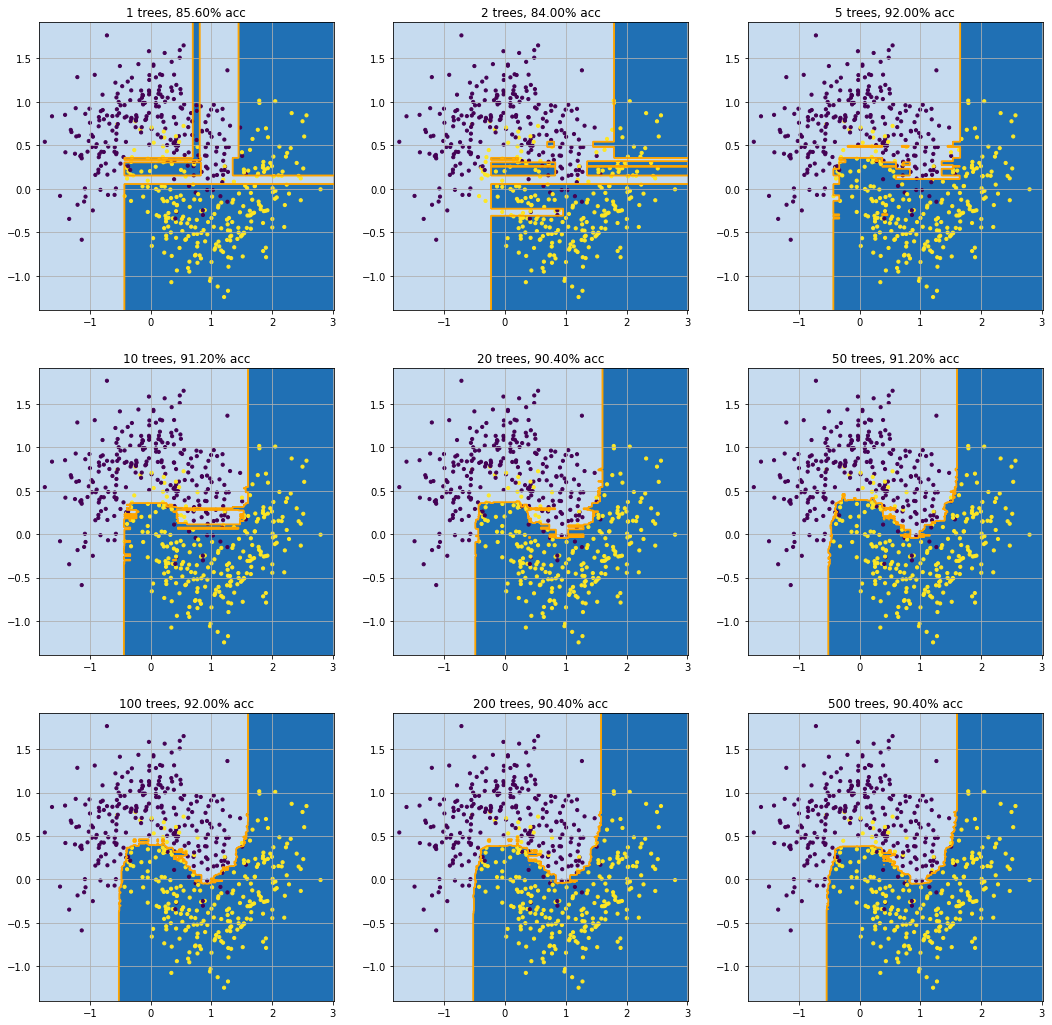

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
bag_sizes = [1, 2, 5, 10, 20, 50, 100, 200, 500]; n_bag_sizes = len(bag_sizes)
nrows = ncols = int(np.ceil(np.sqrt(n_bag_sizes)));
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 18))
for i, bag_size in enumerate(bag_sizes):
    ax = axes.flat[i]
    clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=bag_size, 
        max_samples=100, bootstrap=True, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    ax.grid(); ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max);
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=1000), np.linspace(y_min, y_max, num=1000))
    zz = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ax.contour(xx, yy, zz.reshape(xx.shape), 1, colors='orange', linestyles='solid')
    ax.contourf(xx, yy, zz.reshape(xx.shape), 1, cmap='Blues'); ax.scatter(*X.T, c=y, s=10)
    ax.set_title('{} trees, {:.2%} acc'.format(bag_size, acc))

**Ejemplo:** $\;$ clasificación de correos en spam y no-spam

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
df = pd.read_csv("https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/data/Spam.txt?raw=True")
is_test = df.test.values; y = df.spam.values; X = df.drop(['test','spam'], axis=1).to_numpy(copy=True)
X_train, X_test = X[is_test == 0], X[is_test == 1]
y_train, y_test = y[is_test == 0], y[is_test == 1]
ntrees_list = [10, 50, 100, 200, 300, 400, 500]
for ntrees in ntrees_list:
    clf = BaggingClassifier(n_estimators=ntrees, random_state=10, bootstrap=True).fit(X_train, y_train)
    y_test_hat = clf.predict(X_test)
    acc = accuracy_score(y_test, y_test_hat)
    print(f'Bagged {ntrees} trees, test err {1 - acc:.1%}')

Bagged 10 trees, test err 5.9%
Bagged 50 trees, test err 5.5%
Bagged 100 trees, test err 5.4%
Bagged 200 trees, test err 5.5%
Bagged 300 trees, test err 5.5%
Bagged 400 trees, test err 5.4%
Bagged 500 trees, test err 5.6%


## 2.3 Random forests

**Random forests:** $\;$ variante de bagging de árboles que mejora la decorrelación de modelos base mediante aleatorización, no solo de datos, sino también de variables de entrada; así, la característica de split $j_i$ se optimiza sobre un conjunto aleatorio $S_i\subseteq\{1,\dotsc,D\}$,
$$(j_i,t_i)=\operatorname*{arg}
\min_{j\in S_i}\min_{t\in\mathcal{T}_j}\;%
\frac{\lvert\mathcal{D}_i^L(j,t)\rvert}{\lvert\mathcal{D}_i\rvert}\,c(\mathcal{D}_i^L(j,t))+%
\frac{\lvert\mathcal{D}_i^R(j,t)\rvert}{\lvert\mathcal{D}_i\rvert}\,c(\mathcal{D}_i^R(j,t))$$

**Ventaja frente a bagging:** $\;$ los bosques suelen ser más precisos que bagging pues muchas características son irrelevantes

**Ventaja frente a boosting:** $\;$ los aprendices pueden entrenarse en paralelo, cosa que no puede hacerse en boosting

**Ejemplo:** $\;$ clasificación de correos en spam y no-spam

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
df = pd.read_csv("https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/data/Spam.txt?raw=True")
is_test = df.test.values; y = df.spam.values; X = df.drop(['test','spam'], axis=1).to_numpy(copy=True)
X_train, X_test = X[is_test == 0], X[is_test == 1]
y_train, y_test = y[is_test == 0], y[is_test == 1]
ntrees_list = [10, 50, 100, 200, 300, 400, 500]
for ntrees in ntrees_list:
    clf = RandomForestClassifier(n_estimators=ntrees, random_state=10).fit(X_train, y_train)
    y_test_hat = clf.predict(X_test)
    acc = accuracy_score(y_test, y_test_hat)
    print(f'RF {ntrees} trees, test err {1 - acc:.1%}')

RF 10 trees, test err 6.3%
RF 50 trees, test err 5.0%
RF 100 trees, test err 4.9%
RF 200 trees, test err 4.8%
RF 300 trees, test err 4.9%
RF 400 trees, test err 4.8%
RF 500 trees, test err 4.8%


# 3 Boosting

## 3.1 Boosting

**Modelo aditivo de funciones base adaptativas:** $\;$ ensamble visto como suma de modelos base, no necesariamente árboles
$$f(\boldsymbol{x};\boldsymbol{\theta})%
=\sum_{m=1}^M \beta_m\,F_m(\boldsymbol{x};\boldsymbol{\theta}_m)$$

**Objetivo:** $\;$ minimizar la pérdida empírica (con regularizador)
$$\mathcal{L}(f)=\sum_{i=1}^N\ell(y_i,f(\boldsymbol{x}_i))$$

**Boosting (potenciación):** $\;$ ajusta secuencialmente modelos aditivos de clasificadores binarios, $F_m\in\{-1, +1\}$
* Primero ajusta $F_1$ a los datos y se ponderan con más peso los errores
* Luego ajusta $F_2$ a los datos ponderados en el paso anterior
* El proceso sigue hasta llegar a $M$ componentes
* Si la precisión de cada **weak learner** $F_m$ es mejor que el azar ($50\%$), la del **strong learner** $f$ será aún mejor

**Ventaja frente a bagging y bosques:** $\;$ ofrece mejores resultados pues reduce el sesgo del aprendiz fuerte ajustando árboles que dependen unos de otros; bagging y bosques solo reducen la varianza ajustando árboles independientes

**Evolución:** $\;$ propuesto en aprendizaje PAC para clasificación binaria con pérdida específica; actualmente se plantea bajo un marco estadístico general, con pérdidas diversas para extender su aplicación a regresión, clasificación multi-clase, ranking, etc.

**Ejemplo:** $\;$ clasificación de correos en spam y no-spam

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
df = pd.read_csv("https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/data/Spam.txt?raw=True")
is_test = df.test.values; y = df.spam.values; X = df.drop(['test','spam'], axis=1).to_numpy(copy=True)
X_train, X_test = X[is_test == 0], X[is_test == 1]
y_train, y_test = y[is_test == 0], y[is_test == 1]
ntrees_list = [10, 50, 100, 200, 300, 400, 500]
for ntrees in ntrees_list:
    clf = CatBoostClassifier(iterations=ntrees, random_state=10, learning_rate=0.2, verbose=False).fit(X_train, y_train)
    y_test_hat = clf.predict(X_test)
    acc = accuracy_score(y_test, y_test_hat)
    print(f'Boosting {ntrees} trees, test err {1 - acc:.1%}')

Boosting 10 trees, test err 6.2%
Boosting 50 trees, test err 5.4%
Boosting 100 trees, test err 4.7%
Boosting 200 trees, test err 4.6%
Boosting 300 trees, test err 4.8%
Boosting 400 trees, test err 4.6%
Boosting 500 trees, test err 4.4%


## 3.2 Modelado aditivo por etapas hacia adelante

**Forward stagewise additive modeling (FSAM):** $\;$ optimiza la empı́rica con pérdida genérica y $f$ modelo aditivo

**Objetivo FSAM (para el modelo base $m$):** $\;$ empírica con pérdida genérica, $\,\ell(y, \hat{y})$
$$L_m(\beta,\boldsymbol{\theta})%
=\sum_{i=1}^N\ell(y_i, f_{m-1}(\boldsymbol{x}_i)+\beta F(\boldsymbol{x}_i;\boldsymbol{\theta}))$$

**Minimización del objetivo y reajuste del modelo:** $\quad(\beta_m,\boldsymbol{\theta}_m)=\operatorname*{argmin}_{\beta,\boldsymbol{\theta}}\;L_m(\beta,\boldsymbol{\theta})$
$$f_m(\boldsymbol{x})=f_{m-1}(\boldsymbol{x})+\beta_m F_m(\boldsymbol{x})%
\qquad\text{con}\qquad%
F_m(\boldsymbol{x})=F(\boldsymbol{x};\boldsymbol{\theta}_m)$$

## 3.3 Boosting mínimos cuadrados

**Objetivo FSAM con pérdida cuadrática:** $\;\ell(y,\hat{y})=(y-\hat{y})^2$
$$L_m(\beta,\boldsymbol{\theta})%
=\sum_{i=1}^N (r_{im}-\beta F(\boldsymbol{x}_i;\boldsymbol{\theta}))^2
\qquad\text{con residuos}\qquad r_{im}=y_i-f_{m-1}(\boldsymbol{x}_i)$$

**Boosting mínimos cuadrados:** $\;$ minimiza el objetivo fijando $\beta=1$ y ajustando $F$ a los residuos

**Ejemplo:** $\;$ regresión simple con boosting mínimos cuadrados

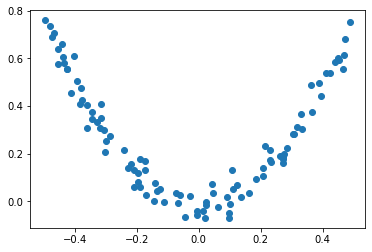

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)
fig, ax = plt.subplots(figsize=(6, 4));  ax.scatter(X, y)
x_min, x_max = ax.get_xlim(); y_min, y_max = ax.get_ylim()

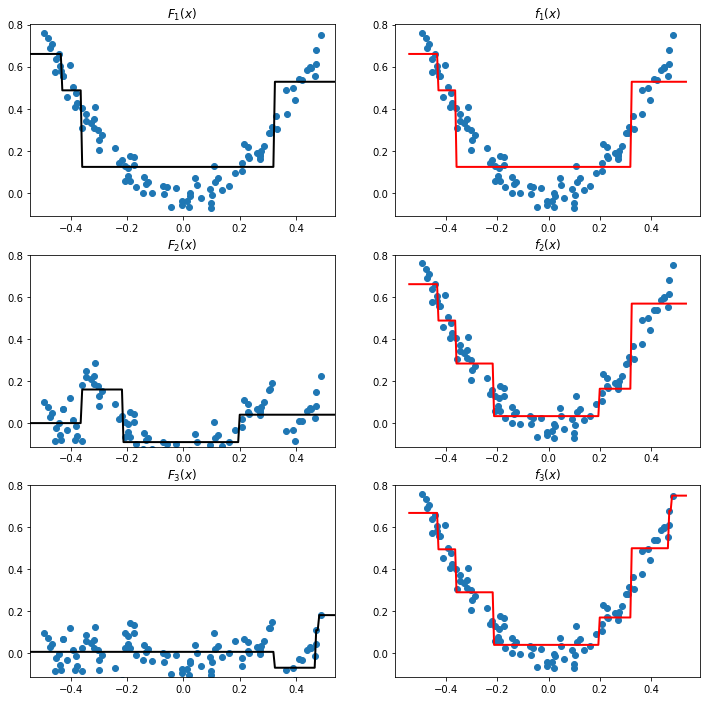

In [2]:
from sklearn.tree import DecisionTreeRegressor
M = 3; fig, axes = plt.subplots(M, 2, figsize=(12, M * 4))
res = np.copy(y); tt = []; xx = np.linspace(x_min, x_max, 200)
for m in np.arange(M):
    tree = DecisionTreeRegressor(max_depth=2, random_state=42)
    tree.fit(X, res); tt.append(tree)
    ax = axes[m, 0]
    ax.set_title('$F_{}(x)$'.format(m+1))
    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.scatter(X, res)
    res_pred = tree.predict(xx.reshape(-1, 1))
    ax.plot(xx, res_pred, 'k-', linewidth=2)
    ax = axes[m, 1]
    ax.set_title('$f_{}(x)$'.format(m+1))
    ax.scatter(X, y)
    y_pred = sum(t.predict(xx.reshape(-1, 1)) for t in tt)
    ax.plot(xx, y_pred, 'r-', linewidth=2)
    res -= tree.predict(X)

## 3.4 AdaBoost

### 3.4.1 Objetivo FSAM con pérdida exponencial

Si $\;\ell(\tilde{y},\hat{y})=\exp(-\tilde{y}\hat{y})\;$ con $\;\tilde{y}\in\{-1,+1\}$
$$\begin{align*}
L_m(\beta,\boldsymbol{\theta})%
&=\sum_{i=1}^N \exp(-\tilde{y}_i(f_{m-1}(\boldsymbol{x}_i)+\beta F(\boldsymbol{x}_i;\boldsymbol{\theta})))\\%
&=\sum_{i=1}^N w_{im}\exp(-\beta\tilde{y}_i F(\boldsymbol{x}_i;\boldsymbol{\theta}))%
\qquad\text{con}\qquad w_{im}=\exp(-\tilde{y}_i f_{m-1}(\boldsymbol{x}_i))\\%
&=e^{\beta}\sum_{\tilde{y}_i\neq F(\boldsymbol{x}_i;\boldsymbol{\theta})} w_{im}
+e^{-\beta}\sum_{\tilde{y}_i=F(\boldsymbol{x}_i;\boldsymbol{\theta})} w_{im}\\%
&=e^{\beta}\sum_{\tilde{y}_i\neq F(\boldsymbol{x}_i;\boldsymbol{\theta})} w_{im}
+e^{-\beta}\left(\sum_{i=1}^N w_{im}-\sum_{\tilde{y}_i\neq F(\boldsymbol{x}_i;\boldsymbol{\theta})} w_{im}\right)\\%
&=(e^{\beta}-e^{-\beta})\sum_{i=1}^N w_{im}\mathbb{I}(\tilde{y}_i\neq F(\boldsymbol{x}_i;\boldsymbol{\theta}))%
+e^{-\beta}\sum_{i=1}^N w_{im}
\end{align*}$$

### 3.4.2 Minimización del objetivo en dos pasos

Primero hallamos $\boldsymbol{\theta}_m$ a partir de los datos ponderados:
$$\boldsymbol{\theta}_m=\operatorname*{argmin}_{\boldsymbol{\theta}}%
\sum_{i=1}^N w_{im}\mathbb{I}(\tilde{y}_i\neq F(\boldsymbol{x}_i;\boldsymbol{\theta}))$$

Luego obtenemos $\beta_m$ mediante minimización en $\beta$ de $L_m(\beta,\boldsymbol{\theta}_m)$:
$$\beta_m=\operatorname*{argmin}_{\beta}\;L_m(\beta,\boldsymbol{\theta}_m)%
=\frac{1}{2}\log\frac{1-\operatorname{err}_m}{\operatorname{err}_m}%
\qquad\text{con}\qquad\operatorname{err}_m=\frac{1}{\sum_{i=1}^N w_{im}}%
\sum_{i=1}^N w_{im}\mathbb{I}(\tilde{y}_i\neq F_m(\boldsymbol{x}_i))$$

### 3.4.3 Adaboost

**Adaboost:** $\;$ halla $F_m(\cdot)$ y $\beta_m$ en la iteración $m$ y reajusta el modelo

**Pesos de los datos para la primera iteración:** $\;w_{i1}=1/N$

**Pesos de los datos para la iteración $m+1$:** $\;$ se calculan tras hallar $F_m(\cdot)$ y $\beta_m$ en la iteración $m$
$$\begin{align*}
w_{i,m+1}&=\exp(-\tilde{y}_i f_m(\boldsymbol{x}_i))\\%
&=\exp(-\tilde{y}_i f_{m-1}(\boldsymbol{x}_i)-\tilde{y}_i\beta_m F_m(\boldsymbol{x}_i))\\%
&=w_{im}\exp(-\tilde{y}_i\beta_m F_m(\boldsymbol{x}_i))\\%
&=w_{im}\exp(\beta_m(2\mathbb{I}(\tilde{y}_i\neq F_m(\boldsymbol{x}_i))-1))\\%
&=w_{im}\exp(2\beta_m\mathbb{I}(\tilde{y}_i\neq F_m(\boldsymbol{x}_i)))\exp(-\beta_m)%
\end{align*}$$
El factor $\exp(-\beta_m)$ se puede ignorar ya que es constante para todos los datos en el objetivo FSAM de la iteración $m+1$. Así pues, los pesos de los datos para la iteración $m+1$ son:
$$w_{i,m+1}=\begin{cases}
w_{im}\exp(2\beta_m) & \text{si $\tilde{y}_i\neq F_m(\boldsymbol{x}_i)$}\\%
w_{im}               & \text{en otro caso}%
\end{cases}$$

**Modelo ajustado para clasificación binaria:** $\;f(\boldsymbol{x})=\operatorname{sgn}(\sum_m\beta_m F_m(\boldsymbol{x}))$

**Modelos para regresión y clasificación multi-clase:** $\;$ se usan variantes de Adaboost convenientemente adaptadas

### 3.4.4 Propiedades de Adaboost

**Sensibilidad a outliers:** $\;$ ya que los pesos de los datos mal clasificados crecen exponencialmente

**Dificultad para estimar probabilidades:** $\;$ en teoría, el riesgo de un modelo $f(\boldsymbol{x})$ con pérdida exponencial es
$$\mathbb{E}[\exp(-\tilde{y}f(\boldsymbol{x}))\mid\boldsymbol{x}]%
=p(\tilde{y}=1\mid\boldsymbol{x})\exp(-f(\boldsymbol{x}))%
+p(\tilde{y}=-1\mid\boldsymbol{x})\exp(f(\boldsymbol{x}))$$
Derivando con respecto a $f(\boldsymbol{x})$ e igualando a cero, tenemos que el modelo de mínimo riesgo teórico halla la mitad de la log-odds:
$$f(\boldsymbol{x})=\frac{1}{2}\log\frac{p(\tilde{y}=1\mid\boldsymbol{x})}{p(\tilde{y}=-1\mid\boldsymbol{x})}$$
Aunque no obtenemos probabilidades directamente, este resultado justifica la aplicación del operador signo al modelo

**Ejemplo:** $\;$ clasificación de correos en spam y no-spam

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
df = pd.read_csv("https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/data/Spam.txt?raw=True")
is_test = df.test.values; y = df.spam.values; X = df.drop(['test','spam'], axis=1).to_numpy(copy=True)
X_train, X_test = X[is_test == 0], X[is_test == 1]
y_train, y_test = y[is_test == 0], y[is_test == 1]
ntrees_list = [10, 50, 100, 200, 300, 400, 500]
for ntrees in ntrees_list:
    clf = AdaBoostClassifier(n_estimators=ntrees, random_state=10, learning_rate=0.2).fit(X_train, y_train)
    y_test_hat = clf.predict(X_test)
    acc = accuracy_score(y_test, y_test_hat)
    print(f'AdaBoosting {ntrees} trees, test err {1 - acc:.1%}')

AdaBoosting 10 trees, test err 10.9%
AdaBoosting 50 trees, test err 7.2%
AdaBoosting 100 trees, test err 5.9%
AdaBoosting 200 trees, test err 5.7%
AdaBoosting 300 trees, test err 5.7%
AdaBoosting 400 trees, test err 5.5%
AdaBoosting 500 trees, test err 5.5%


## 3.5 LogitBoost

**Predicción probabilística:** $\;$ usamos el modelo aditivo para predecir la mitad de la log-odds
$$p(\tilde{y}\mid\boldsymbol{x};\boldsymbol{\theta})%
=\sigma(\tilde{y}a)\qquad\text{con}\qquad a=2f(\boldsymbol{x};\boldsymbol{\theta})$$

**Objetivo FSAM con log-pérdida y $\beta=1$:** $\quad\ell(\tilde{y},\boldsymbol{\theta};\boldsymbol{x})=-\log p(\tilde{y}\mid\boldsymbol{x};\boldsymbol{\theta})$
$$\begin{align*}
L_m(\boldsymbol{\theta})%
&=-\sum_{i=1}^N \log(\sigma(\tilde{y}_i2[f_{m-1}(\boldsymbol{x}_i)+ F(\boldsymbol{x}_i;\boldsymbol{\theta})]))\\%
&=\sum_{i=1}^N \log(1+\exp(-2\tilde{y}_i[f_{m-1}(\boldsymbol{x}_i)+ F(\boldsymbol{x}_i;\boldsymbol{\theta})]))
\end{align*}$$

**LogitBoost:** $\;$ algoritmo de Newton para minimizar este objetivo directamente

## 3.6 Gradient boosting

**Gradient boosting:** $\;$ FSAM visto como descenso por gradiente para un problema de minimización en un espacio funcional
$$\hat{\boldsymbol{f}}%
=\operatorname*{argmin}_{\boldsymbol{f}}\mathcal{L}(\boldsymbol{f})%
\quad\text{con}\quad%
\mathcal{L}(\boldsymbol{f})=\sum_{i=1}^N \ell(y_i,f(\boldsymbol{x}_i))$$

**Funciones base simplificadas:** $\;$ valores en el conjunto de entrenamiento, $\;\boldsymbol{f}=(f(\boldsymbol{x}_1),\dotsc,f(\boldsymbol{x}_N))^t$

**Descenso por gradiente:** $\;$ escoge la "dirección" de máximo descenso, esto es, la del neg-gradiente de $\mathcal{L}(\boldsymbol{f})$ en $\boldsymbol{f}_{m-1}$, $\boldsymbol{g}_m$
$$\boldsymbol{f}_m=\boldsymbol{f}_{m-1}-\beta_m \boldsymbol{g}_m
\qquad\text{con}\qquad%
g_{im}=\left[\frac{\partial\ell(y_i,f(\boldsymbol{x}_i))}{\partial f(\boldsymbol{x}_i)}\right]_{f_{m-1}(\boldsymbol{x}_i)}$$

**Factor de aprendizaje:** $\;\beta_m$ puede escogerse por búsqueda lineal

**Funciones base generalizadas:** $\;$ para poder generalizar, se ajusta un aprendiz débil al neg-gradiente con pérdida cuadrática
$$F_m=\operatorname*{argmin}_F\sum_{i=1}^N(-g_{im}-F(\boldsymbol{x}_i))^2$$

### 3.6.1 Algoritmo básico

El algoritmo básico prescinde de $\beta_m$ pero incluye un **shrinkage factor** $0<\nu\leq 1$ para facilitar la regularización:
1. Inicializar $\,f_0(\boldsymbol{x})=\operatorname{argmin}_F\sum_{i=1}^N\ell(y_i,F(\boldsymbol{x}_i))$
2. **for** $\;m=1:M\;$ **do**
3. $\quad$ Calcular el neg-gradiente o (pseudo-)**residuo** $\,r_{im}=-\left[\dfrac{\partial\ell(y_i,f(\boldsymbol{x}_i))}{\partial f(\boldsymbol{x}_i)}\right]_{f_{m-1}(\boldsymbol{x}_i)}$
4. $\quad$ Usar el aprendiz débil para hallar $\,F_m=\operatorname*{argmin}_F\sum_{i=1}^N(r_{im}-F(\boldsymbol{x}_i))^2$
5. $\quad$ Actualizar $\,f_m(\boldsymbol{x})=f_{m-1}(\boldsymbol{x})+\nu F_m(\boldsymbol{x})$
6. Devolver $\,f(\boldsymbol{x})=f_M(\boldsymbol{x})$

### 3.6.2 Regresión

**Salidas:** $\;y_i\in\mathbb{R}$

**Pérdida cuadrática o su mitad:** $\;\ell(y_i,f(\boldsymbol{x}_i))=\frac{1}{2}(y_i-f(\boldsymbol{x}_i))^2\quad$ (como boosting mínimo cuadrados) 

**Residuo de la pérdida cuadrática:** $\;r_i=y_i-f(\boldsymbol{x}_i)$

**Pérdida valor absoluto:** $\;\ell(y_i,f(\boldsymbol{x}_i))=\lvert y_i-f(\boldsymbol{x}_i)\rvert$

**Residuo de la pérdida valor absoluto:** $\;r_i=\operatorname{sgn}(y_i-f(\boldsymbol{x}_i))$

### 3.6.3 Clasificación binaria

**Salidas:** $\;\tilde{y}_i\in\{-1,+1\}$

**Pérdida exponencial:** $\;\ell(\tilde{y}_i,f(\boldsymbol{x}_i))=\exp(-\tilde{y}_i f(\boldsymbol{x}_i))\quad$ (como Adaboost)

**Residuo de la pérdida exponencial:** $\;r_i=\tilde{y}_i\exp(-\tilde{y}_i f(\boldsymbol{x}_i))$

**Log-pérdida binaria:** $\;\ell(\tilde{y}_i,f(\boldsymbol{x}_i))=\log(1+\exp(-\tilde{y}_i f(\boldsymbol{x}_i)))\quad$ (como LogitBoost)

**Residuo de la log-pérdida binaria:**
$$r_i=-\frac{1}{1+\exp(-\tilde{y}_i f(\boldsymbol{x}_i))}\exp(-\tilde{y}_i f(\boldsymbol{x}_i))(-\tilde{y}_i)%
=\tilde{y}_i\frac{1}{1+\exp(\tilde{y}_i f(\boldsymbol{x}_i))}%
=\tilde{y}_i\sigma(-\tilde{y}_i f(\boldsymbol{x}_i))$$

### 3.6.4 Clasificación multiclase

**Salidas:** $\;y_i\in\{1,\dotsc,C\}$

**Log-pérdida:** $\;$ se ajustan $C$ modelos aditivos, uno por cada clase, cuyas predicciones se normalizan mediante una softmax
$$\ell(y_i,f_1(\boldsymbol{x}_i),\dotsc,f_C(\boldsymbol{x}_i))=-\sum_c \mathbb{I}(y_i=c)\log \pi_{ic}%
\quad\text{con}\quad%
\pi_{ic}=S(f_1(\boldsymbol{x}_i),\dotsc,f_C(\boldsymbol{x}_i))_c%
=\frac{\exp(f_c(\boldsymbol{x}_i))}{\sum_{c'=1}^C \exp(f_{c'}(\boldsymbol{x}_i))}$$

**Residuo de la log-pérdida:** $\;$ para cada clase $c$
$$\begin{align*}
r_{ic}%
&=-\dfrac{\partial\ell(y_i,f_1(\boldsymbol{x}_i),\dotsc,f_C(\boldsymbol{x}_i))}{\partial f_c(\boldsymbol{x}_i)}\\%
&=\frac{\partial}{\partial f_c(\boldsymbol{x}_i)}\sum_{\tilde{c}} \mathbb{I}(y_i=\tilde{c})\log \pi_{i\tilde{c}}\\%
&=\mathbb{I}(y_i=c)\frac{1}{\pi_{ic}}\pi_{ic}(1-\pi_{ic})\\%
&=\mathbb{I}(y_i=c)(1-\pi_{ic})
\end{align*}$$

### 3.6.5 Gradient tree boosting

**Gradient tree boosting:** $\;$ gradient boosting con árbol de regresión como aprendiz débil
$$F_m=\sum_{j=1}^{J_m}w_{jm}\mathbb{I}(\boldsymbol{x}\in R_{jm})$$
* $R_{jm}$ y $w_{jm}$ son la región y salida asociadas a la hoja $j$ del árbol añadido en la iteración $m$
* La salida puede ser un escalar o, más generalmente, un vector (de probabilidades, por ejemplo)

**Aprendizaje de las regiones:** $\;$ CART sobre residuos

**Aprendizaje de las salidas:** $\;$ minimización del riesgo empírico con los datos de la hoja
$$\hat{w}_{jm}=\operatorname*{argmin}_w\sum_{\boldsymbol{x}_i\in R_{jm}}%
\ell(y_i,f_{m-1}(\boldsymbol{x}_i)+w)$$

**Aprendizaje de las salidas con pérdida cuadrática:** $\;\hat{w}_{jm}$ es la media empírica de los residuos de la hoja

### 3.6.6 XGBoost

**Extreme gradient boosting (XGBoost):** $\;$ implementación muy popular de gradient tree boosting con algunos refinamientos
* Objetivo regularizado
* Aproximación de segundo orden de la pérdida
* Muestreo de caracterı́sticas en nodos internos
* Técnicas algorítmicas varias para mejorar la escabilidad

# 4 Interpretación de ensambles de árboles

## 4.1 Importancia de características

**Importancia de una característica $k$ en un árbol $T$:** $\;$ suma de ganancias (reducciones de coste) en los nodos $v_j$ que la usan
$$R_k(T)=\sum_jG_j\mathbb{I}(v_j=k)$$

**Importancia de una característica $k$ en un ensamble de $M$ árboles:** $\;$ extensión mediante promediado
$$R_k=\frac{1}{M}\sum_{m=1}^MR_k(T_m)$$

**Normalización de importancias:** $\;$ suelen normalizarse con respecto a la máxima ($100\%$)

**Ejemplo:** $\;$ importancias para clasificador (de dígitos escogidos en) MNIST

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, parser='auto')
mnist.data = mnist.data.astype(np.float32).to_numpy()
mnist.target = mnist.target.astype(np.uint8).to_numpy()

In [2]:
from sklearn.ensemble import RandomForestClassifier
X = mnist["data"]
y = mnist["target"]
mask = (y == 6) | (y == 9) # <<< escoge dígitos
X_mask = X[mask, :]
y_mask = y[mask]
print(X_mask.shape, y_mask.shape)
clf = RandomForestClassifier(n_estimators=20, random_state=42)
clf.fit(X_mask, y_mask)
image = clf.feature_importances_.reshape(28, 28)

(13834, 784) (13834,)


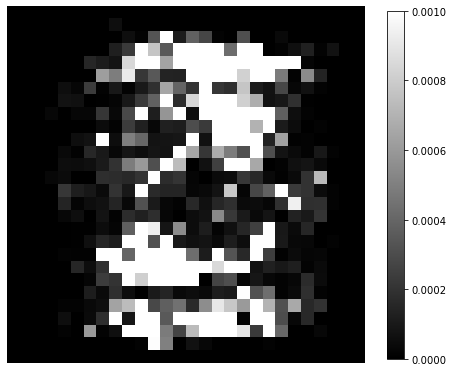

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set(aspect='equal'); ax.axis('off')
plt.imshow(image, cmap='gray', interpolation="none", vmin=0.0, vmax=0.001)
plt.colorbar(ax=ax, shrink=0.8);

## 4.2 Gráficos de dependencia parcial

**Gráfico de dependencia parcial:** $\;$ muestra la predicción del modelo en función de una ($x_k$) o dos ($x_j, x_k$) características
$$\begin{align*}
\bar{f}_k(x_k)&=\frac{1}{N}\sum_{n=1}^N f(\boldsymbol{x}_{n,-k},x_k)\\%
\bar{f}_{jk}(x_j,x_k)&=\frac{1}{N}\sum_{n=1}^N f(\boldsymbol{x}_{n,-jk},x_j,x_k)%
\end{align*}$$

**Gráfico de dependencia parcial en clasificación binaria:** $\;$ muestra la log-odds en función de $x_k$ (y $x_k$)

**Ejemplo:** $\;$ dependencia parcial de log-odds de la clase spam; aumenta con la frecuencia de ch! y remove; edu y hp la disminuyen

In [1]:
import pandas as pd
df = pd.read_csv("https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/data/Spam.txt?raw=True")
X = df.drop(['test','spam'], axis=1); y = df.spam.values; X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=0).fit(X, y)

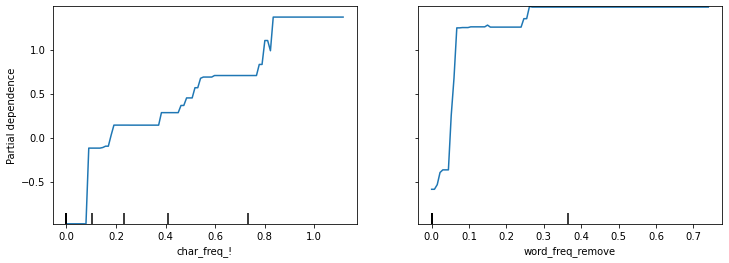

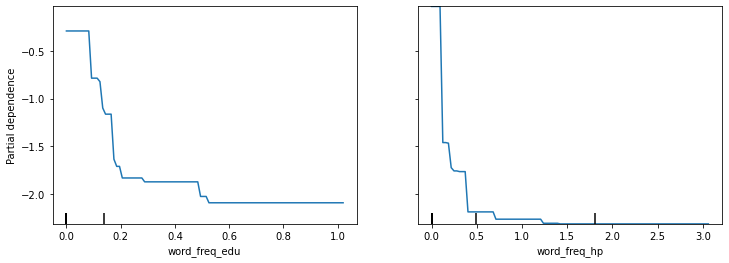

In [3]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(clf, X, ['char_freq_!', 'word_freq_remove'], ax=ax)
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(clf, X, ['word_freq_edu', 'word_freq_hp'], ax=ax);